In [ ]:
%load_ext autoreload
%autoreload 2
import cv2
from pathlib import Path
from tqdm.auto import tqdm
from scipy.io import savemat
import gzip
import pickle
import h5py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from torchinfo import summary

import sys
sys.path += ['../Adversarial_Video_Summary']
from solver import Solver
from data_loader import get_loader
from feature_extraction import resnet_transform, ResNetFeature

tf.config.list_physical_devices('GPU')

In [ ]:
# video_file ='/media/sil2/Data/Lizard/Pogona Data/Lizard15/12.14.2015/16-44-20_videos/2015-12-14_16-44-20-sub-10-fullFile--57370-Converted--1-57370.avi'
# video_file = '/media/sil2/Data/Lizard/Pogona Data/Lizard15/12.14.2015/16-44-20_videos/2015-12-14_16-44-20-allFrames---57370-Converted--42680-57370.avi'
video_file = '/media/sil2/Data/Lizard/Pogona Data/Lizard15/12.14.2015/16-44-20_videos/20151214003_1.AVI'

In [ ]:
def print_gpu_usage():
    print('GPU Usage: Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB', '| Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
def prepare_data_dir(video_name):
    p = f'/media/sil2/Data/regev/SUM_GAN/videos/resnet101_feature/{video_name}'
    Path(f'{p}/train').mkdir(exist_ok=True, parents=True)
    Path(f'{p}/test').mkdir(exist_ok=True, parents=True)
    return p

In [ ]:


BATCH_SIZE = 32
features_path = prepare_data_dir(video_name='pogona_mark4')
vid = cv2.VideoCapture(video_file)
n_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
prev_frame = None
features = []
rsnt = ResNetFeature()

for i in tqdm(range(n_frames)):
    ret, frame = vid.read()
    if i > 0 and cv2.absdiff(frame,prev_frame).mean() < 3:
        continue
    
    PIL_image = Image.fromarray(np.uint8(frame)).convert('RGB')
    x = resnet_transform(PIL_image)
    _, P = rsnt(x.unsqueeze(0).cuda())
    features.append(P)
    if len(features) >= BATCH_SIZE:
        features = torch.stack(features).cpu().detach().numpy()
        mode = 'train' if np.random.random() > 0.2 else 'test'
        with h5py.File(f'{features_path}/{mode}/{i}.h5', 'w') as f:
            f.create_dataset("pool5", data=features)
        features = []
    
    prev_frame = frame

In [ ]:
# Read Mark's Excel

exps = pd.read_excel('/media/sil2/Data/Lizard/SleepExp.xlsx')
exps = exps.query('VideoFiles==VideoFiles and VideoFiles!="-"')
for i, row in exps.iterrows():
    folder = row["folder"].replace('\\', '/').replace('Z:/', '/media/sil2/Data/')
    print(f'{folder}/{row["VideoFiles"]}')

In [ ]:
with open('/home/regev/SUM_GAN/score/pogona_mark2_49.json', 'r') as f:
    scores = json.load(f)
    
S = []
for k, v in scores.items():
    S.append(v)

S = np.vstack(S)
S[:,2]

In [ ]:
from configs import Config


config = Config(mode='train', preprocessed=True, video_type='pogona_mark2', epoch=2, input_size=2048, hidden_size=500, num_layers=2, lr=1e-4, discriminator_lr=1e-5)
test_config = Config(mode='test', preprocessed=True, video_type='pogona_mark2', epoch=2, input_size=2048, hidden_size=500, num_layers=2, lr=1e-4, discriminator_lr=1e-5)
train_loader = get_loader(config.video_root_dir, config.mode)
test_loader = get_loader(test_config.video_root_dir, test_config.mode)
solver = Solver(config, train_loader, test_loader)
solver.build()
model = solver.model
checkpoint = torch.load('/home/regev/SUM_GAN/cache/pogona_mark2_epoch-49.pkl')
model.load_state_dict(checkpoint)
model.eval()
summary(model, input_size=(32,2048))

In [ ]:
%load_ext tensorboard
from solver import Solver
from data_loader import get_loader

train_loader = get_loader(Path(features_path), 'train')
test_loader = get_loader(Path(features_path), 'test')
solver = Solver(features_path, train_loader, test_loader)
solver.build()
solver.train()

In [76]:
len(frame_ids)

28810

In [80]:
%%time

BATCH_SIZE = 32
features_path = '/media/sil2/Data/regev/SUM_GAN/videos/resnet101_feature/pogona_mark3'
Path(f'{features_path}/train').mkdir(exist_ok=True, parents=True)
Path(f'{features_path}/test').mkdir(exist_ok=True, parents=True)

vid = cv2.VideoCapture(video_file)
n_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
features = []
prev_frame = None
for i in tqdm(range(n_frames)):
    ret, frame = vid.read()
    if not ret:
        print(f'no frame {i}; Abort.')
        break
    
    if i > 0 and cv2.absdiff(frame,prev_frame).mean() < 3:
        continue
    
    prev_frame = frame
    
    frame = image.smart_resize(frame, (224, 224))
    x = image.img_to_array(frame)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    if len(features) < BATCH_SIZE:
        features.append(x)
        continue
    
    features_ = np.vstack(features[1:] + [x])
    P = model.predict(features_, batch_size=BATCH_SIZE)
    with h5py.File(f'{features_path}/train/{i}.h5', 'w') as f:
        f.create_dataset("pool5", data=P)

  0%|          | 0/311174 [00:00<?, ?it/s]

CPU times: user 1h 33min 22s, sys: 7min 21s, total: 1h 40min 43s
Wall time: 1h 21min 25s


In [13]:
%%time
f = np.load('/media/sil2/Data/regev/video_features.npz')
features = f['arr_0']

CPU times: user 10min 59s, sys: 1min 17s, total: 12min 17s
Wall time: 12min 17s


In [7]:
idx = np.random.choice(np.arange(features.shape[0]), size=features.shape[0]//2, replace=False)
features = features[idx, :]
features.shape

(216000, 100352)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(features)

PCA(n_components=100)

In [3]:
vid = cv2.VideoCapture(video_file)
n_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

frames = []
for i in range(n_frames):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame)

In [4]:
n_frames = len(frames)
test_idx = np.random.choice(np.arange(n_frames), int(n_frames*0.2))

In [6]:
for i, frame in enumerate(frames):
    fldr = 'test' if i in test_idx else 'train'
    cv2.imwrite(f'/media/sil2/Data/regev/SUM_GAN/videos/video_subshot/pogona_mark1/{fldr}/{i}.jpg', frame)

In [10]:
pcs = pca.transform(features)

In [57]:
%matplotlib notebook
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
c = np.arange(pcs.shape[0])
norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

# x, y = pcs[:,0], pcs[:,1]
x, y = X_embedded[:, 0], X_embedded[: ,1]
fig, ax = plt.subplots()
sc = ax.scatter(x,y)
im = OffsetImage(frames[0], zoom=0.1)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points", bbox=dict(boxstyle="round", fc="w"), arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)
ab.set_visible(False)

xybox=(100., 100.)


def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    annot.set_text(f'{ind["ind"]}')
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def update_annot_image(ind, event):
    # get the figure size
    w,h = fig.get_size_inches() * fig.dpi
    ws = (event.x > w/2.)*-1 + (event.x <= w/2.)
    hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
    # if event occurs in the top or right quadrant of the figure,
    # change the annotation box position relative to mouse.
    ab.xybox = (xybox[0]*ws, xybox[1]*hs)
    # # make annotation box visible
    ab.set_visible(True)
    # place it at the position of the hovered scatter point
    pos = sc.get_offsets()[ind["ind"][0]]
    ab.xy = pos
    # set the image corresponding to that point
    im.set_data(frames[ind["ind"][0]])

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            # update_annot(ind)
            update_annot_image(ind, event)
            fig.canvas.draw_idle()
        else:
            if vis:
                ab.set_visible(False)
                fig.canvas.draw_idle()

                
fig.canvas.mpl_connect("motion_notify_event", hover)

8

In [12]:
from mpl_toolkits import mplot3d
%matplotlib tk

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(pcs[:,0], pcs[:,1],pcs[:,2])

In [23]:
%matplotlib inline

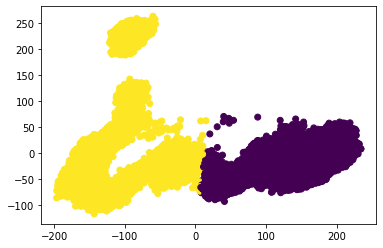

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(pcs[:,:2])
plt.scatter(pcs[:,0], pcs[:,1], c=kmeans.labels_)

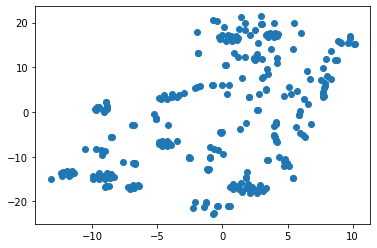

In [56]:
%matplotlib inline
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(pcs)
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [4]:
rootdir, channel = '/media/sil2/Data/Lizard/Pogona Data/Lizard15/12.14.2015/18-26-12_cheetah', 32  # mark
video_file = f'{Path(rootdir).parent}/18-26-12_videos/2015-12-14_18-26-12-sub-10-fullFile--614316-Converted--1-614316.avi'

In [3]:
rd = NeuralynxReader(rootdir, channel=channel)
sc = rd.load_slow_cycles()
print(f'Reader initialized. fs={rd.fs:.0f}Hz, duration={rd.time_vector[-1]/3600:.1f} hours')

Reader initialized. fs=32000Hz, duration=17.1 hours


In [11]:
vid = cv2.VideoCapture(video_file)
pics = []
for _ in range(3):
  ret, frame = vid.read()
  gray = cv2.cvtColor(frame ,cv2.COLOR_BGR2GRAY)
  gray = cv2.resize(gray, (0, 0), fx=0.3, fy=0.3)
  pics.append(gray)

In [ ]:
descriptors = np.array([])
for pic in pics:
    kp, des = cv2.SIFT().detectAndCompute(pic, None)
    descriptors = np.append(descriptors, des)

desc = np.reshape(descriptors, (len(descriptors)/128, 128))
desc = np.float32(desc)
desc.shape

In [ ]:
del descriptors, des, kp, pic

In [20]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)
des

array([[ 0.,  0.,  0., ...,  0.,  0., 30.],
       [ 0., 23., 79., ..., 28., 11.,  0.],
       [ 8., 52., 79., ..., 10.,  9.,  1.],
       ...,
       [ 3.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1., 15., 11., ...,  0.,  0.,  1.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)